In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
import tensorflow as tf
print(tf.config.experimental.list_physical_devices('GPU'))
from model_DbyDeep_train import get_npy_DbyDeep

2023-03-21 00:22:47.886107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-21 00:22:48.860861: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-21 00:22:48.861791: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-21 00:22:48.899508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2023-03-21 00:22:48.899537: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-03-21 00:22:48.903973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-03-21 00:22:48.904022: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-0

In [2]:
# gpu setting
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

# HPP

In [3]:
print('Loading model...')
model = keras.models.load_model("log/model_DbyDeep_04_False.h5")
model.summary()

Loading model...


2023-03-21 00:22:50.004819: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 00:22:50.008385: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-21 00:22:50.010022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2023-03-21 00:22:50.010105: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-03-21 00:22:50.010132: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Succ

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0                                            
______________________________________________________________________________________________

In [5]:
df_hpp = pd.read_csv('/data/2021_SJH_detectability/data_human/HPP.csv')
df_hpp.rename({'Class':'label'}, axis=1, inplace=True)

In [6]:
print('Loading input peptides')
pep_hpp, n_hpp, c_hpp, m1_hpp, m2_hpp, label_hpp = get_npy_DbyDeep(df_hpp)

print('Making predictions')
model_pred = model.predict([pep_hpp, n_hpp, c_hpp, m1_hpp, m2_hpp])

Loading input peptides
Making predictions


2022-12-17 00:50:08.208160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-17 00:50:08.231308: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2022-12-17 00:50:17.865404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-17 00:50:19.042071: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-17 00:50:19.146082: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-17 00:50:19.147753: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


In [7]:
df_hpp = pd.concat([df_hpp, pd.DataFrame(model_pred, columns=['probs'])['probs']], axis=1)

pe = df_hpp.loc[df_hpp['label']=='PE1'][['peptide', 'probs']].drop_duplicates()
dmp = df_hpp.loc[df_hpp['label']=='Detected_MPs'][['peptide', 'probs']].drop_duplicates()
mp = df_hpp.loc[df_hpp['label']=='MPs'][['peptide', 'probs']].drop_duplicates()

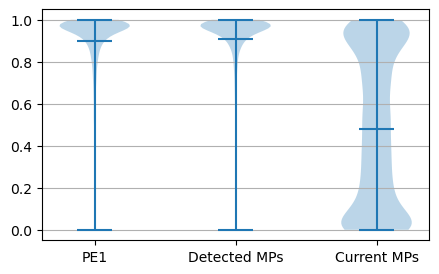

In [8]:
plt.figure(figsize=(5,3))
a = plt.violinplot([pe.probs.astype(float), 
                    dmp.probs.astype(float), 
                    mp.probs.astype(float)],
               showmeans=True,
              )
plt.xticks([y + 1 for y in range(len([pe,dmp,mp]))], ['PE1', 'Detected MPs', 'Current MPs'])
b = plt.grid(axis='y')
plt.show()

TEST Accuracy : 0.8445408842865123
TEST AUC : 0.8545995360659234
              precision    recall  f1-score   support

           0     0.8378    0.5204    0.6420      6234
           1     0.8459    0.9631    0.9007     17039

    accuracy                         0.8445     23273
   macro avg     0.8418    0.7418    0.7714     23273
weighted avg     0.8437    0.8445    0.8314     23273



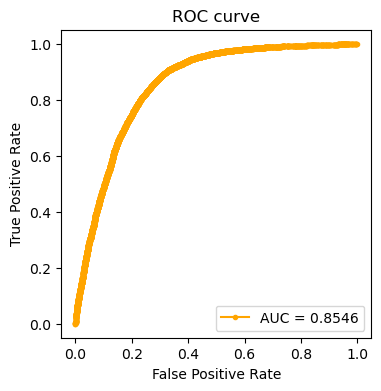

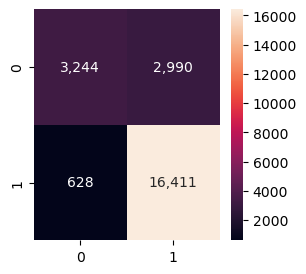

In [9]:
hpp_prob = np.concatenate([pe.probs.values, dmp.probs.values, mp.probs.values])
hpp_pred = np.array([1 if _ >= 0.5 else 0 for _ in hpp_prob])
hpp_true = np.array([1]*len(pe) + [1]*len(dmp) + [0]*len(mp))

auc = roc_auc_score(hpp_true, hpp_prob)
acc = accuracy_score(hpp_true,hpp_pred)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(hpp_true, hpp_pred, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(hpp_true, hpp_prob)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(hpp_true, hpp_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [10]:
np.save('log/result_HPP_DbyDeep_fpr.npy', fpr)
np.save('log/result_HPP_DbyDeep_tpr.npy', tpr)
np.save('log/result_HPP_DbyDeep_threshold.npy', threshold)
np.save('log/result_HPP_DbyDeep_prob.npy', hpp_prob)
np.save('log/result_HPP_DbyDeep_true.npy', hpp_true)

# massIVE-KB

In [18]:
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')

In [19]:
print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

Loading input peptides


In [20]:
probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

5335/5335 [==============================] - 82s 15ms/step - loss: 0.3625 - accuracy: 0.8391


Test Loss: 0.36247390508651733
Test Accuracy: 0.8390507698059082
Test AUC : 0.9192430546754715
              precision    recall  f1-score   support

       False     0.8506    0.8278    0.8390     86495
        True     0.8278    0.8506    0.8391     84211

    accuracy                         0.8391    170706
   macro avg     0.8392    0.8392    0.8391    170706
weighted avg     0.8394    0.8391    0.8391    170706



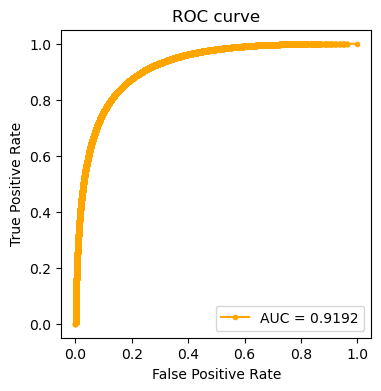

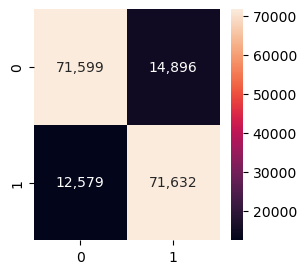

In [21]:
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [14]:
np.save('log/result_DbyDeep_fpr.npy', fpr)
np.save('log/result_DbyDeep_tpr.npy', tpr)

In [22]:
np.save('log/result_massivekb_ypred_dbydeep.npy', np.array(y_pred))
np.save('log/result_massivekb_yprob_dbydeep.npy', np.array(probs))
np.save('log/result_massivekb_ytrue_dbydeep.npy', np.array(label_test))

# Case of missed cleavage sites count

Test AUC : 0.8971147198283145
              precision    recall  f1-score   support

       False     0.8271    0.5858    0.6858     10970
        True     0.8948    0.9664    0.9293     40007

    accuracy                         0.8845     50977
   macro avg     0.8610    0.7761    0.8075     50977
weighted avg     0.8803    0.8845    0.8769     50977



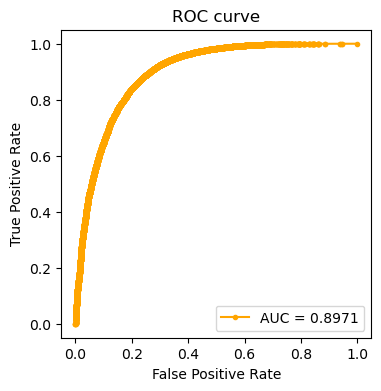

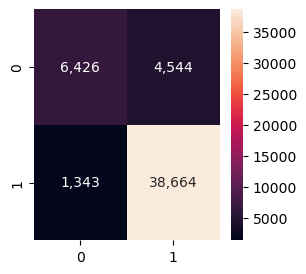

Test AUC : 0.8715288241074701
              precision    recall  f1-score   support

       False     0.7937    0.7631    0.7781     31745
        True     0.7817    0.8105    0.7959     33229

    accuracy                         0.7873     64974
   macro avg     0.7877    0.7868    0.7870     64974
weighted avg     0.7876    0.7873    0.7872     64974



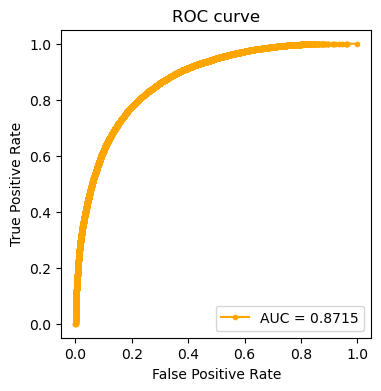

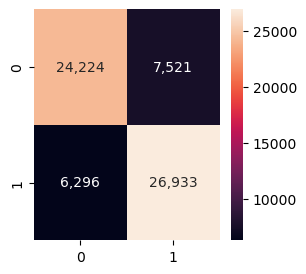

Test AUC : 0.8866303301556447
              precision    recall  f1-score   support

       False     0.8923    0.9353    0.9133     43780
        True     0.6807    0.5499    0.6083     10975

    accuracy                         0.8581     54755
   macro avg     0.7865    0.7426    0.7608     54755
weighted avg     0.8499    0.8581    0.8522     54755



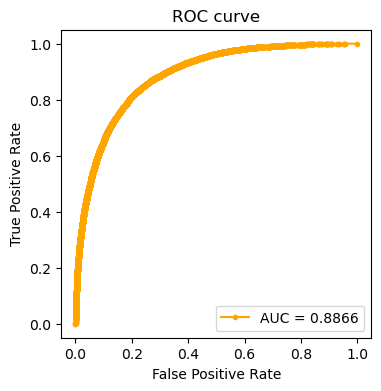

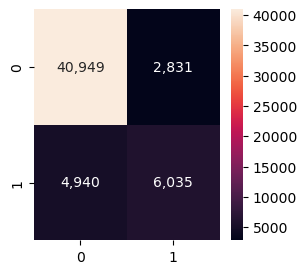

In [18]:
miss0_idx = df_test.loc[df_test.miss1=='ZZZZZZZZZZZZZZZ'].index
miss1_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2=='ZZZZZZZZZZZZZZZ')].index
miss2_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2!='ZZZZZZZZZZZZZZZ')].index

y_pred = np.array(y_pred)
probs_miss0 = probs[miss0_idx]
probs_miss1 = probs[miss1_idx]
probs_miss2 = probs[miss2_idx]
y_pred_miss0 = y_pred[miss0_idx]
y_pred_miss1 = y_pred[miss1_idx]
y_pred_miss2 = y_pred[miss2_idx]
label_test_miss0 = label_test[miss0_idx]
label_test_miss1 = label_test[miss1_idx]
label_test_miss2 = label_test[miss2_idx]

auc = roc_auc_score(label_test_miss0, probs_miss0)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss0, y_pred_miss0, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss0, probs_miss0)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss0, y_pred_miss0)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(label_test_miss1, probs_miss1)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss1, y_pred_miss1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss1, probs_miss1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss1, y_pred_miss1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(label_test_miss2, probs_miss2)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss2, y_pred_miss2, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss2, probs_miss2)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss2, y_pred_miss2)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()



# Cross Species - Mouse

Loading input peptides
47321/47321 [==============================] - 770s 16ms/step - loss: 0.8058 - accuracy: 0.6678
Test Loss: 0.8057513236999512
Test Accuracy: 0.6677560806274414
Test AUC : 0.905574326901805
              precision    recall  f1-score   support

       False     0.9966    0.6521    0.7884   1436847
        True     0.1292    0.9582    0.2277     77417

    accuracy                         0.6678   1514264
   macro avg     0.5629    0.8051    0.5080   1514264
weighted avg     0.9522    0.6678    0.7597   1514264



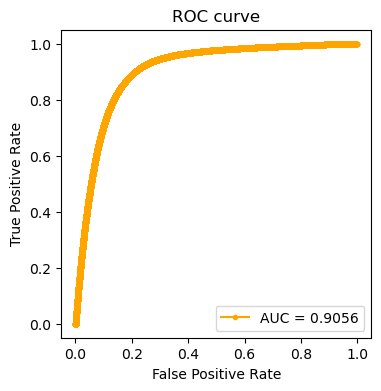

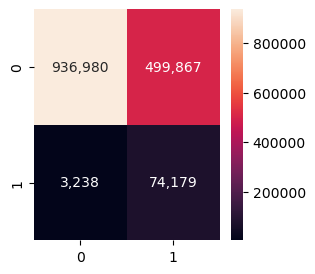

In [12]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_KLife_DbyDeep_fpr.npy', fpr)
np.save('log/result_mouse_KLife_DbyDeep_tpr.npy', tpr)
np.save('log/result_mouse_KLife_DbyDeep_threshold.npy', threshold)
np.save('log/result_mouse_KLife_DbyDeep_probs.npy', probs)
np.save('log/result_mouse_KLife_DbyDeep_true.npy', label_test)

Loading input peptides


2023-03-20 02:42:00.281651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-20 02:42:00.301788: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2023-03-20 02:42:08.305983: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-03-20 02:42:09.132602: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-03-20 02:42:09.231737: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-20 02:42:09.232589: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


45847/45847 [==============================] - 1782s 39ms/step - loss: 0.7975 - accuracy: 0.6709
Test Loss: 0.7975394129753113
Test Accuracy: 0.6709049344062805
Test AUC : 0.9034395573497964
              precision    recall  f1-score   support

       False     0.9963    0.6541    0.7897   1385968
        True     0.1396    0.9586    0.2437     81134

    accuracy                         0.6709   1467102
   macro avg     0.5679    0.8063    0.5167   1467102
weighted avg     0.9489    0.6709    0.7595   1467102



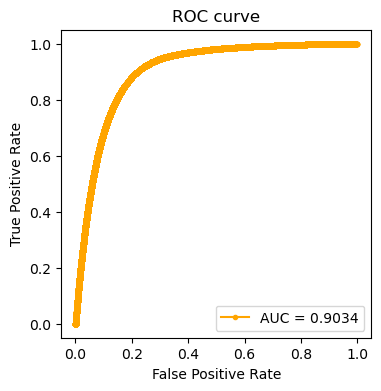

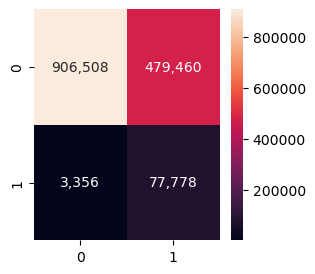

In [4]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_eph4/data.csv')
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_KLife_msgf_DbyDeep_fpr.npy', fpr)
np.save('log/result_mouse_KLife_msgf_DbyDeep_tpr.npy', tpr)
np.save('log/result_mouse_KLife_msgf_DbyDeep_threshold.npy', threshold)
np.save('log/result_mouse_KLife_msgf_DbyDeep_probs.npy', probs)
np.save('log/result_mouse_KLife_msgf_DbyDeep_true.npy', label_test)

Loading input peptides
41477/41477 [==============================] - 633s 15ms/step - loss: 0.8255 - accuracy: 0.6637
Test Loss: 0.825473964214325
Test Accuracy: 0.6636941432952881
Test AUC : 0.8845754807193095
              precision    recall  f1-score   support

       False     0.9952    0.6483    0.7851   1257916
        True     0.1288    0.9432    0.2266     69343

    accuracy                         0.6637   1327259
   macro avg     0.5620    0.7958    0.5059   1327259
weighted avg     0.9499    0.6637    0.7559   1327259



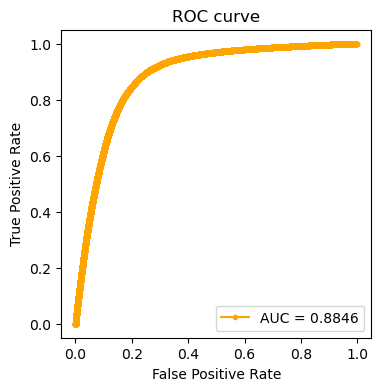

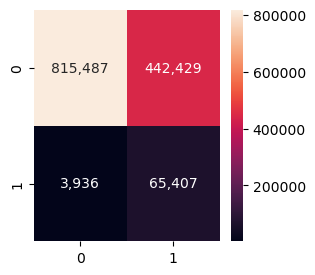

In [13]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_SkeletaMuscle_DbyDeep_fpr.npy', fpr)
np.save('log/result_mouse_SkeletaMuscle_DbyDeep_tpr.npy', tpr)
np.save('log/result_mouse_SkeletaMuscle_DbyDeep_threshold.npy', threshold)
np.save('log/result_mouse_SkeletaMuscle_DbyDeep_probs.npy', probs)
np.save('log/result_mouse_SkeletaMuscle_DbyDeep_true.npy', label_test)

Loading input peptides
41754/41754 [==============================] - 1186s 28ms/step - loss: 0.8230 - accuracy: 0.6645
Test Loss: 0.823049783706665
Test Accuracy: 0.6644667387008667
Test AUC : 0.8834759549358228
              precision    recall  f1-score   support

       False     0.9950    0.6489    0.7855   1265197
        True     0.1307    0.9419    0.2296     70912

    accuracy                         0.6645   1336109
   macro avg     0.5629    0.7954    0.5075   1336109
weighted avg     0.9491    0.6645    0.7560   1336109



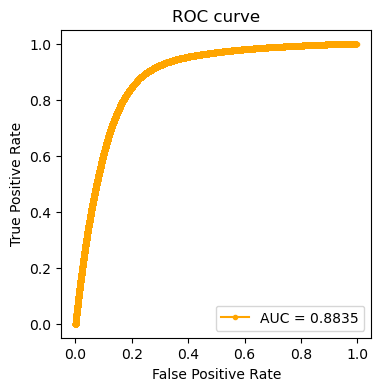

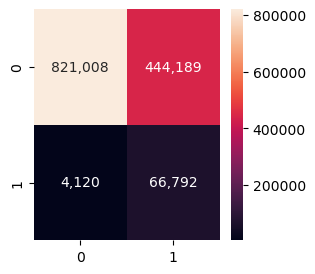

In [5]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_tmuscle/data.csv')
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_mouse_msgf_SkeletaMuscle_DbyDeep_fpr.npy', fpr)
np.save('log/result_mouse_msgf_SkeletaMuscle_DbyDeep_tpr.npy', tpr)
np.save('log/result_mouse_msgf_SkeletaMuscle_DbyDeep_threshold.npy', threshold)
np.save('log/result_mouse_msgf_SkeletaMuscle_DbyDeep_probs.npy', probs)
np.save('log/result_mouse_msgf_SkeletaMuscle_DbyDeep_true.npy', label_test)

# Cross Species - Human

Loading input peptides
62371/62371 [==============================] - 951s 15ms/step - loss: 0.7647 - accuracy: 0.6833
Test Loss: 0.7646703720092773
Test Accuracy: 0.6833379864692688
Test AUC : 0.8828842038756406
              precision    recall  f1-score   support

       False     0.9928    0.6655    0.7969   1862789
        True     0.1661    0.9328    0.2820    133071

    accuracy                         0.6833   1995860
   macro avg     0.5795    0.7992    0.5394   1995860
weighted avg     0.9377    0.6833    0.7625   1995860



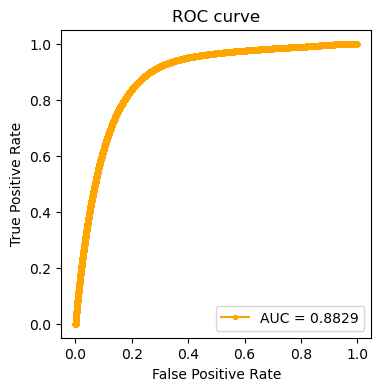

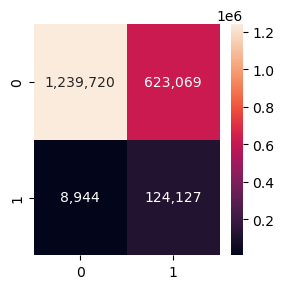

In [14]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/test.csv'),
])

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HEK293_DbyDeep_fpr.npy', fpr)
np.save('log/result_human_HEK293_DbyDeep_tpr.npy', tpr)
np.save('log/result_human_HEK293_DbyDeep_threshold.npy', threshold)
np.save('log/result_human_HEK293_DbyDeep_probs.npy', probs)
np.save('log/result_human_HEK293_DbyDeep_true.npy', label_test)

Loading input peptides
57979/57979 [==============================] - 1153s 20ms/step - loss: 0.7488 - accuracy: 0.6882
Test Loss: 0.748757541179657
Test Accuracy: 0.6881721615791321
Test AUC : 0.893187231848764
              precision    recall  f1-score   support

       False     0.9940    0.6684    0.7993   1723461
        True     0.1793    0.9471    0.3015    131848

    accuracy                         0.6882   1855309
   macro avg     0.5866    0.8077    0.5504   1855309
weighted avg     0.9361    0.6882    0.7639   1855309



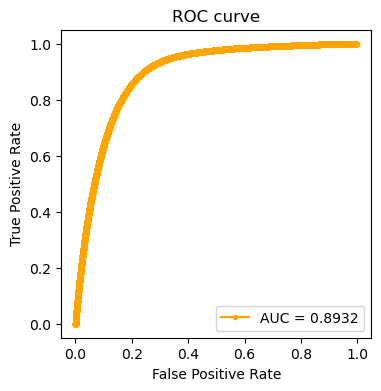

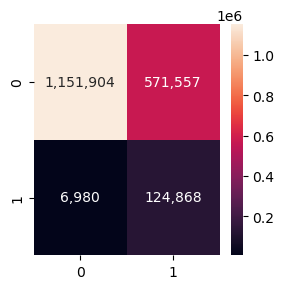

In [10]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/human_hek293/data.csv')

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_msgf_HEK293_DbyDeep_fpr.npy', fpr)
np.save('log/result_human_msgf_HEK293_DbyDeep_tpr.npy', tpr)
np.save('log/result_human_msgf_HEK293_DbyDeep_threshold.npy', threshold)
np.save('log/result_human_msgf_HEK293_DbyDeep_probs.npy', probs)
np.save('log/result_human_msgf_HEK293_DbyDeep_true.npy', label_test)

Loading input peptides
46799/46799 [==============================] - 712s 15ms/step - loss: 0.8630 - accuracy: 0.6501
Test Loss: 0.8629823923110962
Test Accuracy: 0.6500962376594543
Test AUC : 0.8586291429762057
              precision    recall  f1-score   support

       False     0.9938    0.6404    0.7789   1441079
        True     0.0892    0.8984    0.1622     56470

    accuracy                         0.6501   1497549
   macro avg     0.5415    0.7694    0.4705   1497549
weighted avg     0.9597    0.6501    0.7556   1497549



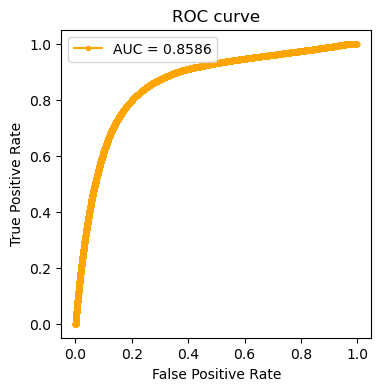

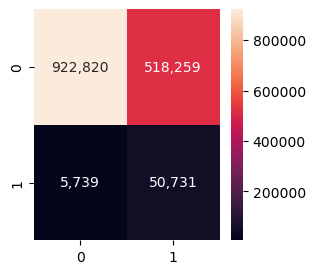

In [15]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/test.csv'),
])

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_HmapLiver_DbyDeep_fpr.npy', fpr)
np.save('log/result_human_HmapLiver_DbyDeep_tpr.npy', tpr)
np.save('log/result_human_HmapLiver_DbyDeep_threshold.npy', threshold)
np.save('log/result_human_HmapLiver_DbyDeep_probs.npy', probs)
np.save('log/result_human_HmapLiver_DbyDeep_true.npy', label_test)

Loading input peptides
 8895/36836 [======>.......................] - ETA: 9:47 - loss: 0.8346 - accuracy: 0.6574

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36836/36836 [==============================] - 779s 21ms/step - loss: 0.8365 - accuracy: 0.6570
Test Loss: 0.8364547491073608
Test Accuracy: 0.657045841217041
Test AUC : 0.8861195936198664
              precision    recall  f1-score   support

       False     0.9951    0.6438    0.7818   1125108
        True     0.1111    0.9340    0.1986     53621

    accuracy                         0.6570   1178729
   macro avg     0.5531    0.7889    0.4902   1178729
weighted avg     0.9549    0.6570    0.7553   1178729



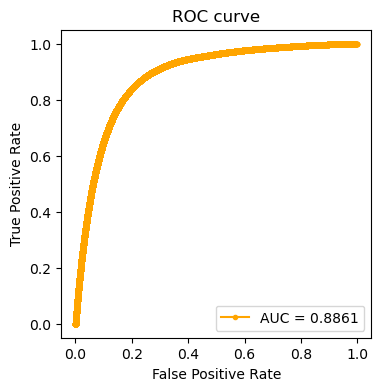

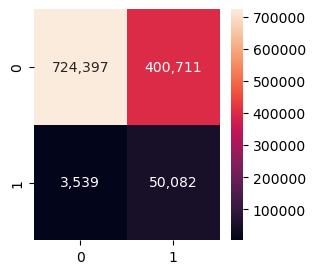

In [7]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/human_liver/data.csv')

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_human_msgf_HmapLiver_DbyDeep_fpr.npy', fpr)
np.save('log/result_human_msgf_HmapLiver_DbyDeep_tpr.npy', tpr)
np.save('log/result_human_msgf_HmapLiver_DbyDeep_threshold.npy', threshold)
np.save('log/result_human_msgf_HmapLiver_DbyDeep_probs.npy', probs)
np.save('log/result_human_msgf_HmapLiver_DbyDeep_true.npy', label_test)

# Cross Species - Yeast

Loading input peptides
17349/17349 [==============================] - 270s 16ms/step - loss: 0.8647 - accuracy: 0.6517
Test Loss: 0.8647148609161377
Test Accuracy: 0.6517312526702881
Test AUC : 0.8729963523440634
              precision    recall  f1-score   support

       False     0.9933    0.6339    0.7739    521986
        True     0.1393    0.9325    0.2423     33160

    accuracy                         0.6517    555146
   macro avg     0.5663    0.7832    0.5081    555146
weighted avg     0.9423    0.6517    0.7421    555146



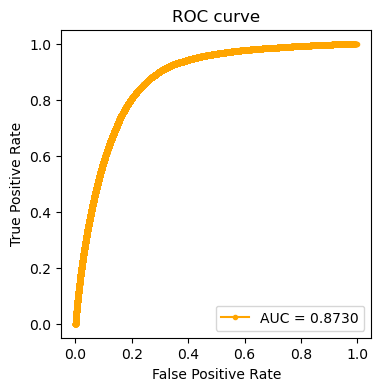

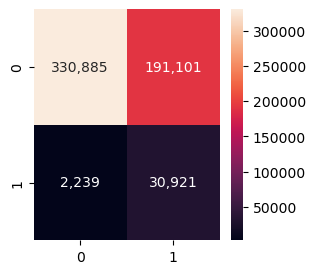

In [16]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_DelPBP1_DbyDeep_fpr.npy', fpr)
np.save('log/result_yeast_DelPBP1_DbyDeep_tpr.npy', tpr)
np.save('log/result_yeast_DelPBP1_DbyDeep_threshold.npy', threshold)
np.save('log/result_yeast_DelPBP1_DbyDeep_probs.npy', probs)
np.save('log/result_yeast_DelPBP1_DbyDeep_true.npy', label_test)

Loading input peptides
18446/18446 [==============================] - 317s 17ms/step - loss: 0.8824 - accuracy: 0.6466
Test Loss: 0.8824222683906555
Test Accuracy: 0.6466265916824341
Test AUC : 0.8431199393645563
              precision    recall  f1-score   support

       False     0.9894    0.6317    0.7711    556165
        True     0.1289    0.8894    0.2252     34086

    accuracy                         0.6466    590251
   macro avg     0.5592    0.7606    0.4982    590251
weighted avg     0.9397    0.6466    0.7396    590251



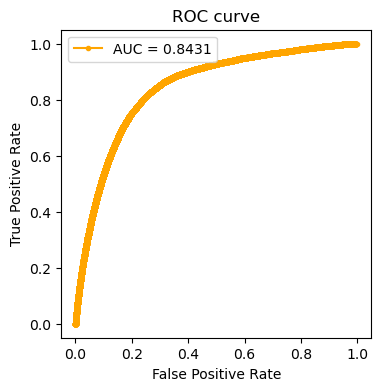

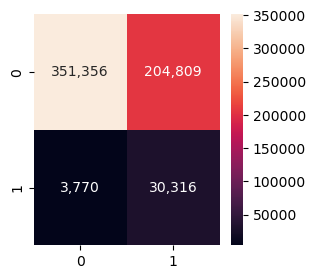

In [11]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/yeast_25/data.csv')
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_msgf_DelPBP1_DbyDeep_fpr.npy', fpr)
np.save('log/result_yeast_msgf_DelPBP1_DbyDeep_tpr.npy', tpr)
np.save('log/result_yeast_msgf_DelPBP1_DbyDeep_threshold.npy', threshold)
np.save('log/result_yeast_msgf_DelPBP1_DbyDeep_probs.npy', probs)
np.save('log/result_yeast_msgf_DelPBP1_DbyDeep_true.npy', label_test)

Loading input peptides
20044/20044 [==============================] - 312s 16ms/step - loss: 0.6742 - accuracy: 0.7105
Test Loss: 0.674227774143219
Test Accuracy: 0.7105196118354797
Test AUC : 0.906037488554098
              precision    recall  f1-score   support

       False     0.9871    0.6790    0.8046    562874
        True     0.2893    0.9365    0.4420     78520

    accuracy                         0.7105    641394
   macro avg     0.6382    0.8078    0.6233    641394
weighted avg     0.9017    0.7105    0.7602    641394



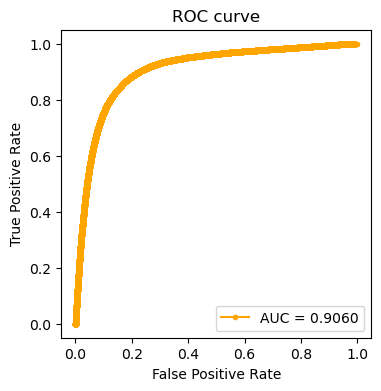

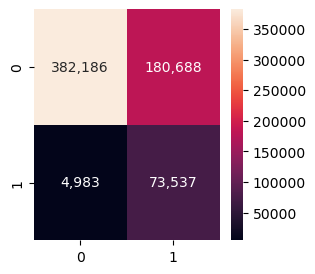

In [17]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_KLife_DbyDeep_fpr.npy', fpr)
np.save('log/result_yeast_KLife_DbyDeep_tpr.npy', tpr)
np.save('log/result_yeast_KLife_DbyDeep_threshold.npy', threshold)
np.save('log/result_yeast_KLife_DbyDeep_probs.npy', probs)
np.save('log/result_yeast_KLife_DbyDeep_true.npy', label_test)

Loading input peptides
20065/20065 [==============================] - 350s 17ms/step - loss: 0.6568 - accuracy: 0.7177
Test Loss: 0.6567922234535217
Test Accuracy: 0.7177108526229858
Test AUC : 0.9065390659454746
              precision    recall  f1-score   support

       False     0.9865    0.6848    0.8084    558429
        True     0.3082    0.9373    0.4638     83636

    accuracy                         0.7177    642065
   macro avg     0.6473    0.8111    0.6361    642065
weighted avg     0.8981    0.7177    0.7635    642065



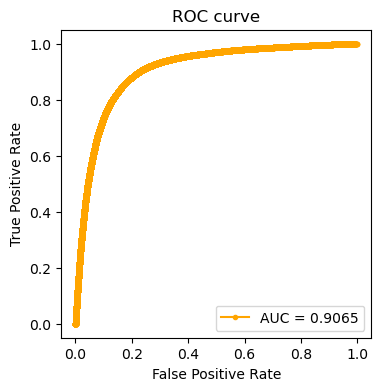

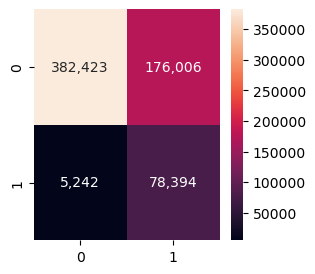

In [12]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/yeast_23/data.csv')
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_yeast_msgf_KLife_DbyDeep_fpr.npy', fpr)
np.save('log/result_yeast_msgf_KLife_DbyDeep_tpr.npy', tpr)
np.save('log/result_yeast_msgf_KLife_DbyDeep_threshold.npy', threshold)
np.save('log/result_yeast_msgf_KLife_DbyDeep_probs.npy', probs)
np.save('log/result_yeast_msgf_KLife_DbyDeep_true.npy', label_test)

# GRU LSTM Transformer

Test AUC : 0.9106635917168169
              precision    recall  f1-score   support

       False     0.8397    0.8238    0.8316     86495
        True     0.8224    0.8384    0.8304     84211

    accuracy                         0.8310    170706
   macro avg     0.8311    0.8311    0.8310    170706
weighted avg     0.8312    0.8310    0.8310    170706



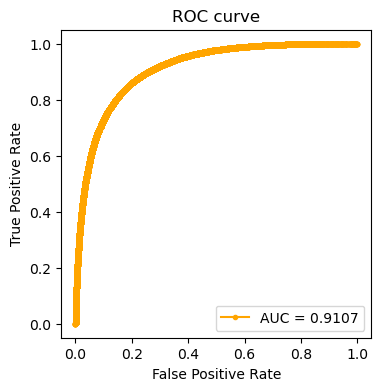

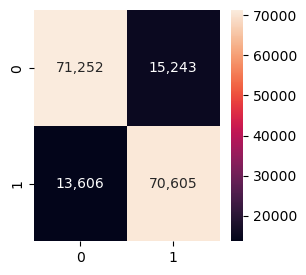

In [20]:
path='/home/bis/2021_SJH_detectability/DbyDeep/revision/log/model_DbyDeep_gru.h5'

model = tf.keras.models.load_model(path)
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)
probs = model.predict(pep_test)
y_pred = [1 if i>=0.5 else 0 for i in probs]

auc = roc_auc_score(label_test, probs)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

Test AUC : 0.9101186776733103
              precision    recall  f1-score   support

       False     0.8376    0.8227    0.8301     86495
        True     0.8212    0.8362    0.8286     84211

    accuracy                         0.8293    170706
   macro avg     0.8294    0.8294    0.8293    170706
weighted avg     0.8295    0.8293    0.8294    170706



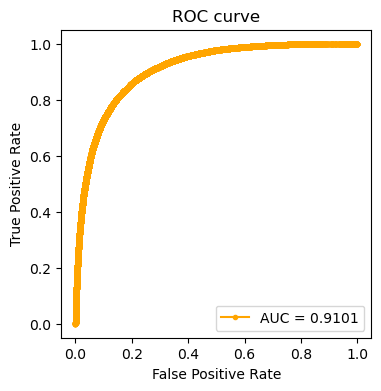

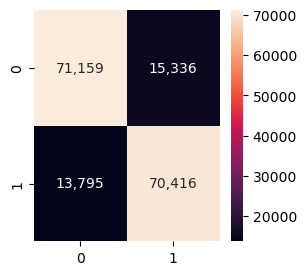

In [21]:
path='/home/bis/2021_SJH_detectability/DbyDeep/revision/log/model_DbyDeep_lstm.h5'

model = tf.keras.models.load_model(path)
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)
probs = model.predict(pep_test)
y_pred = [1 if i>=0.5 else 0 for i in probs]

auc = roc_auc_score(label_test, probs)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

Test AUC : 0.884062694089799
              precision    recall  f1-score   support

       False     0.8003    0.8031    0.8017     86495
        True     0.7970    0.7942    0.7956     84211

    accuracy                         0.7987    170706
   macro avg     0.7987    0.7986    0.7986    170706
weighted avg     0.7987    0.7987    0.7987    170706



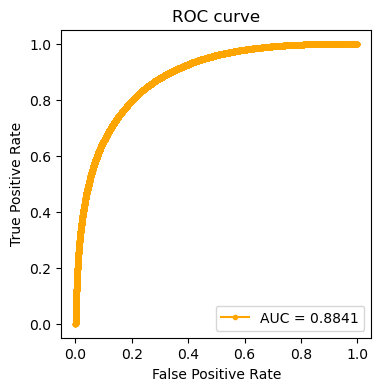

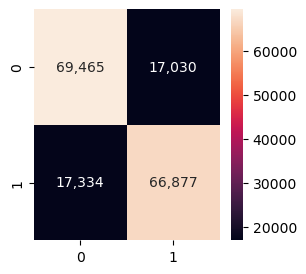

In [22]:
path='/home/bis/2021_SJH_detectability/DbyDeep/revision/log/model_DbyDeep_transformer.h5'

model = tf.keras.models.load_model(path)
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)
probs = model.predict(pep_test)
y_pred = [1 if i>=0.5 else 0 for i in probs]

auc = roc_auc_score(label_test, probs)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

Test AUC : 0.8820231415340145
              precision    recall  f1-score   support

       False     0.7994    0.8008    0.8001     86495
        True     0.7950    0.7936    0.7943     84211

    accuracy                         0.7973    170706
   macro avg     0.7972    0.7972    0.7972    170706
weighted avg     0.7972    0.7973    0.7973    170706



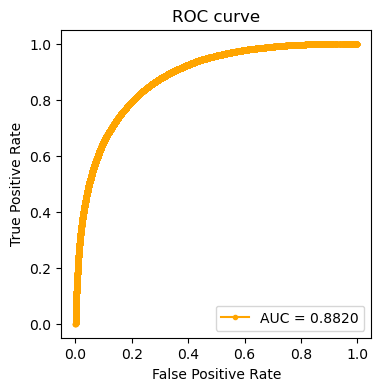

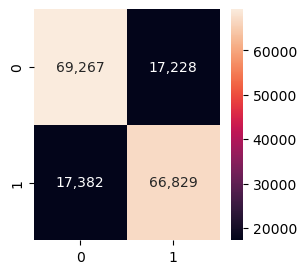

In [23]:
path='/home/bis/2021_SJH_detectability/DbyDeep/revision/log/model_DbyDeep_transformer_large.h5'

model = tf.keras.models.load_model(path)
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)
probs = model.predict(pep_test)
y_pred = [1 if i>=0.5 else 0 for i in probs]

auc = roc_auc_score(label_test, probs)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# retrain by M.eph4

In [4]:
print('Loading model...')
model = keras.models.load_model("data/DbyDeep_retrained.h5")
model.summary()

Loading model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0                                            
_____________________________________________________________________________

Loading input peptides


2023-03-21 00:29:21.605003: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-21 00:29:21.626046: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2023-03-21 00:29:29.035446: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-03-21 00:29:29.702555: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-03-21 00:29:29.786410: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-21 00:29:29.786708: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


41477/41477 [==============================] - 660s 16ms/step - loss: 0.1725 - accuracy: 0.9400
Test Loss: 0.17249292135238647
Test Accuracy: 0.9399906396865845
Test AUC : 0.8719870807973378
              precision    recall  f1-score   support

       False     0.9519    0.9865    0.9689   1257916
        True     0.2815    0.0958    0.1429     69343

    accuracy                         0.9400   1327259
   macro avg     0.6167    0.5411    0.5559   1327259
weighted avg     0.9169    0.9400    0.9258   1327259



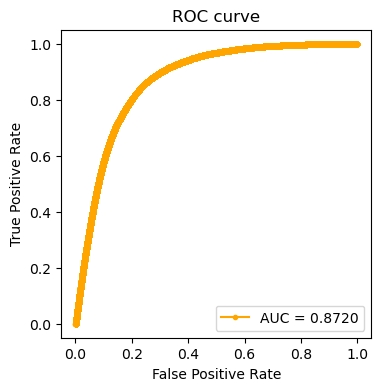

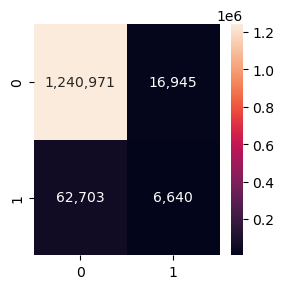

In [5]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()  
# 8846 AUC
# 6637 ACC
# 9432 SENSITIVITY
# 6483 SPECIFICITY
# 1288 PRECISION

In [6]:
df_test = pd.read_csv('/data/2021_SJH_detectability/diff_tool/mouse_tmuscle/data.csv')
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
# 8835 AUC
# 6645 ACC
# 9419 SENSITIVITY
# 6489 SPECIFICITY
# 1307 PRECISION

Loading input peptides



KeyboardInterrupt

